In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
# -*- coding: utf-8 -*-

# Importing Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import cv2
import csv
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix

# Show current TensorFlow version
tf.__version__

'1.14.0'

In [0]:
""" ====== 1.Import the data ====== """

import pickle

training_file = '/content/drive/My Drive/train.p'
validation_file = '/content/drive/My Drive/valid.p'
testing_file = '/content/drive/My Drive/test.p'

with open(training_file,mode='rb') as f:
    train = pickle.load(f)
with open(validation_file,mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Mapping ClassID to traffic sign names
signs = []
with open('/content/drive/My Drive/signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

X_train, y_train = train['features'],train['labels']
X_valid,y_valid = valid['features'],valid['labels']
X_test,y_test = test['features'],test['labels']

In [0]:
""" ====== 2.Data Exploration ====== """

## ====== a.Dataset Summary =====
# ====== i.Number of training set ======
n_train = X_train.shape[0]

# ====== Number of validation set ======
n_validation = X_valid.shape[0]

# ====== Number of testing set ======
n_test = X_test.shape[0]

# ====== ii.Shape of traffic image ======
image_shape = X_train[0].shape

# ====== iii.Number of classes/labels ======
n_classes = len(np.unique(y_train))

print("Number of training set: ", n_train)
print("Number of validation set: ", n_validation)
print("Number of testing set: ", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

## ====== b.Exploratory Visualization ======
# ====== i.Plot a sample image for each class/label ======
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    plt.figure(figsize=(20, 20))
    for i in range(43):
        plt.subplot(7, 7, i+1)    
        indx = -1
        while True:
            indx = random.randint(0, len(dataset)-1)
            if dataset_y[indx]==i:
                cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
                plt.imshow(dataset[indx], cmap = cmap)
                plt.xlabel(signs[dataset_y[indx]])
                plt.xticks([])
                plt.yticks([])
                break
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

print('These sample images for each class are chosen in training set')
list_images(X_train, y_train, "Training example")

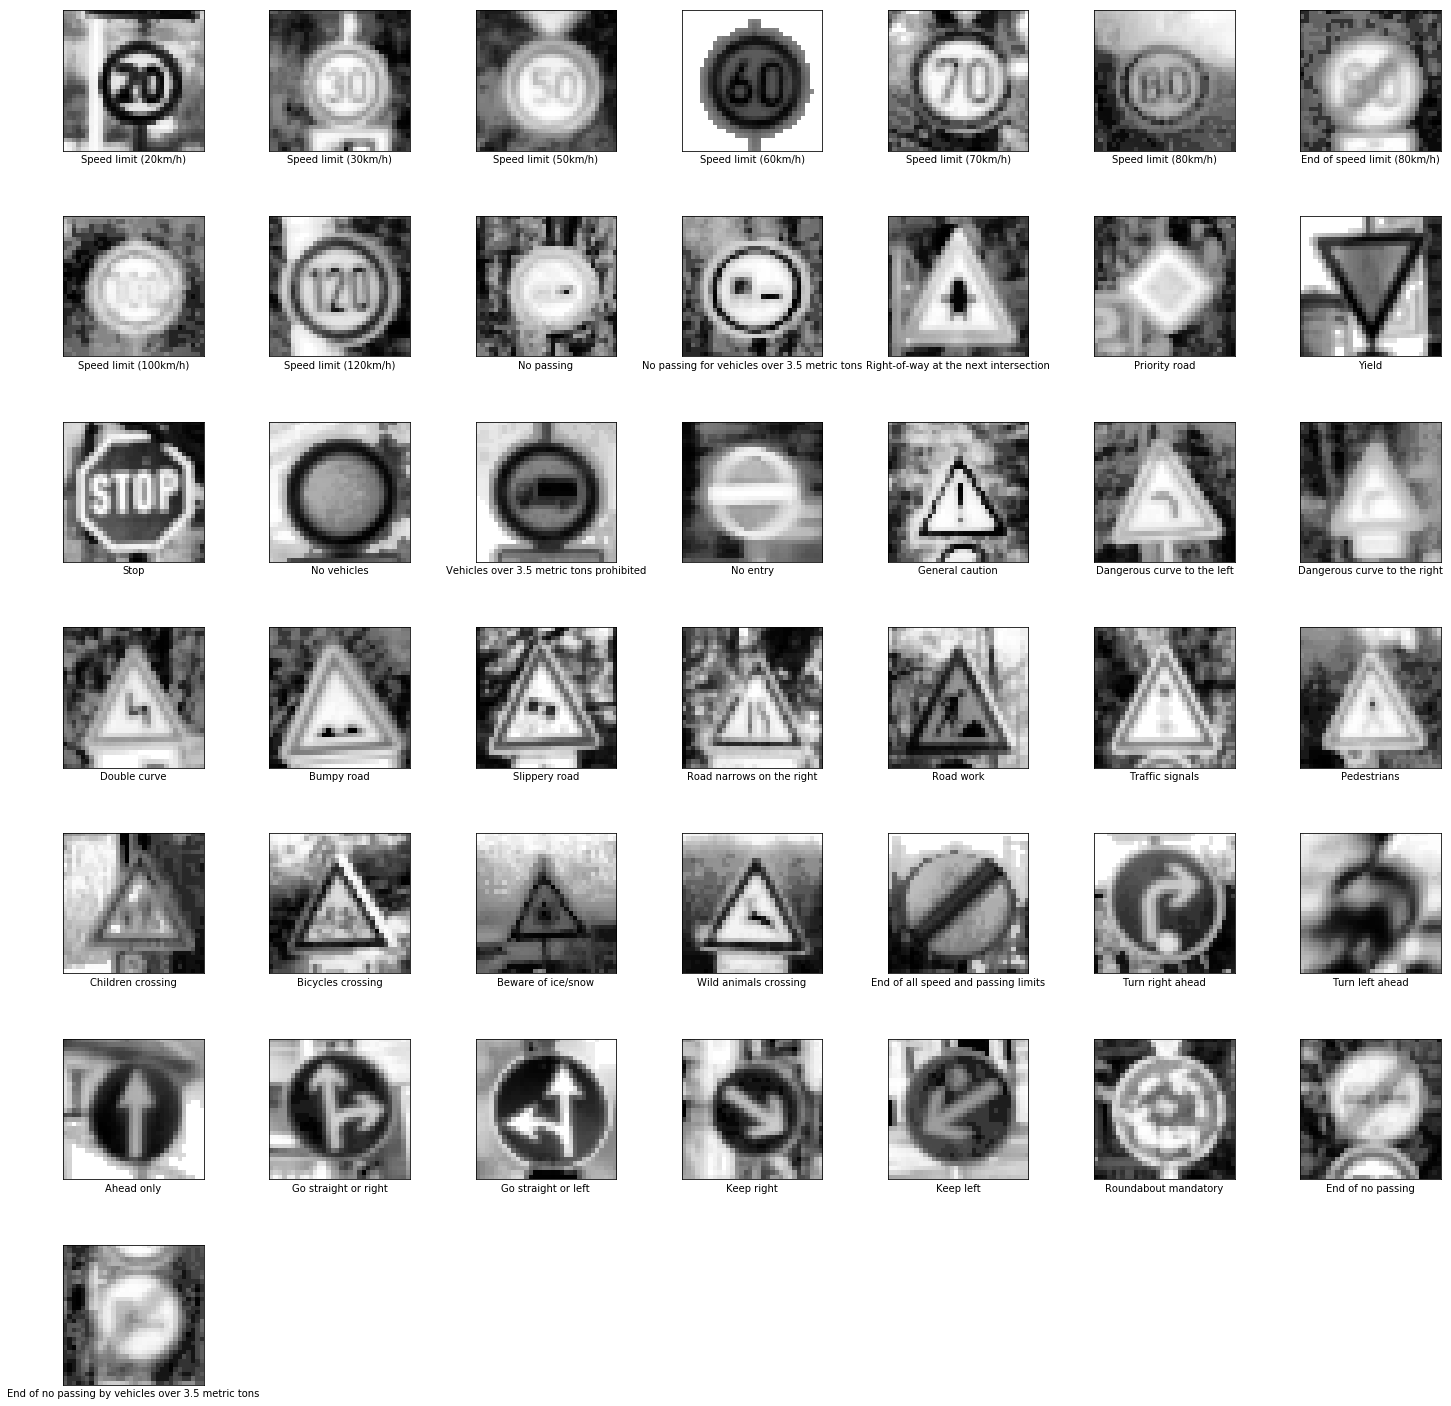

Training...

EPOCH 1 : Validation Accuracy = 26.848%
EPOCH 2 : Validation Accuracy = 45.510%
EPOCH 3 : Validation Accuracy = 61.020%
EPOCH 4 : Validation Accuracy = 83.220%
EPOCH 5 : Validation Accuracy = 90.295%
EPOCH 6 : Validation Accuracy = 94.490%
EPOCH 7 : Validation Accuracy = 96.508%
EPOCH 8 : Validation Accuracy = 95.850%
EPOCH 9 : Validation Accuracy = 98.027%
EPOCH 10 : Validation Accuracy = 97.959%
EPOCH 11 : Validation Accuracy = 98.050%
EPOCH 12 : Validation Accuracy = 98.571%
EPOCH 13 : Validation Accuracy = 98.571%
EPOCH 14 : Validation Accuracy = 98.209%
EPOCH 15 : Validation Accuracy = 98.390%
Model saved
test Accuracy = 96.7%


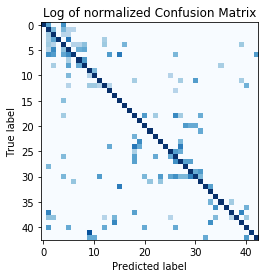

In [96]:
""" ====== 3.Design and Test a Classifier (or model architecture) ====== """

## ====== a.Preprocess ======
# ====== Shuffling ======
X_train, y_train = shuffle(X_train, y_train)

# ====== Grayscaling ======
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray_images = list(map(gray_scale, X_train))

# ====== Local Histogram Equalization ======
def local_histo_equalize(image):
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local
equalized_images = list(map(local_histo_equalize, gray_images))

# ====== Normalization ======
def image_normalize(image):
    image = np.divide(image, 255)
    return image
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")#Sample images after preprocess
normalized_images = normalized_images[..., None]

def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

## ====== b.Design a model architecture & c.Compile the model ======
class VGGnet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2 (Convolutional): Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Layer 3 (Pooling): Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv)

        # Layer 4 (Convolutional): Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 5 (Convolutional): Input = 16x16x64. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = flatten(self.conv6)

        # Layer 10 (Fully Connected): Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 11 (Fully Connected): Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 12 (Fully Connected): Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

X_valid_preprocessed = preprocess(X_valid)   # Validation set preprocessing

EPOCHS = 15
BATCH_SIZE = 64
DIR = 'Saved_Models'

## ====== d.Train VGGNet model ======
VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    VGGNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

## ====== f.Make predictions on test images ======
X_test_preprocessed = preprocess(X_test)    # Test set preprocessing

with tf.Session() as sess:
    VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("test Accuracy = {:.1f}%".format(test_accuracy*100))
    
# ====== Plot the confusion matrix to see where the model actually fails ======
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

004.jpg
003.jpg
005.jpg
002.jpg
001.jpg
008.jpg
007.jpg
006.jpg
009.jpg
010.jpg
Number of new testing examples:  10


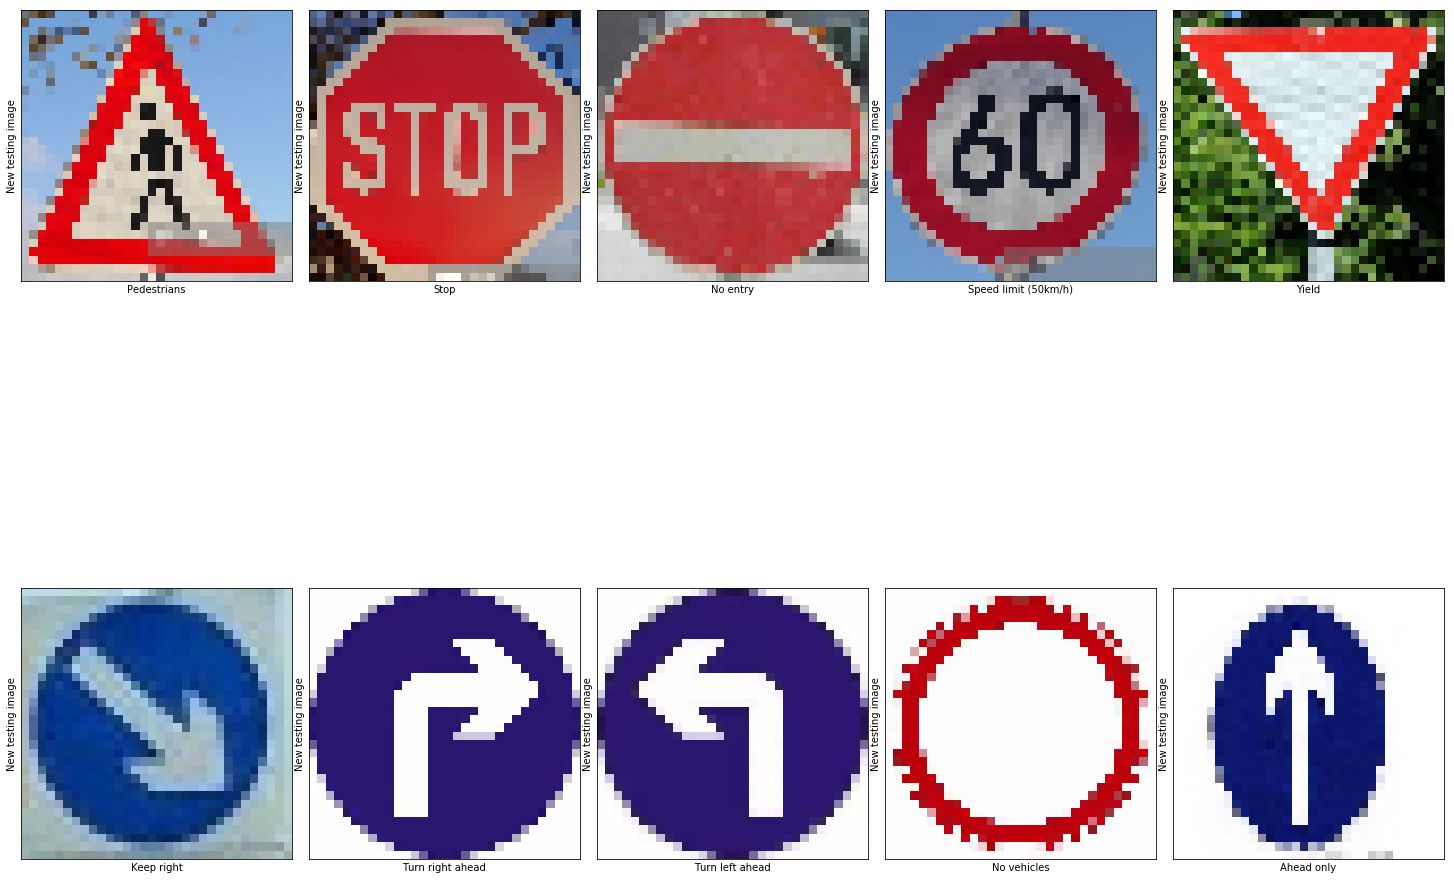

length= 10
New Images Test Accuracy = 100.0%


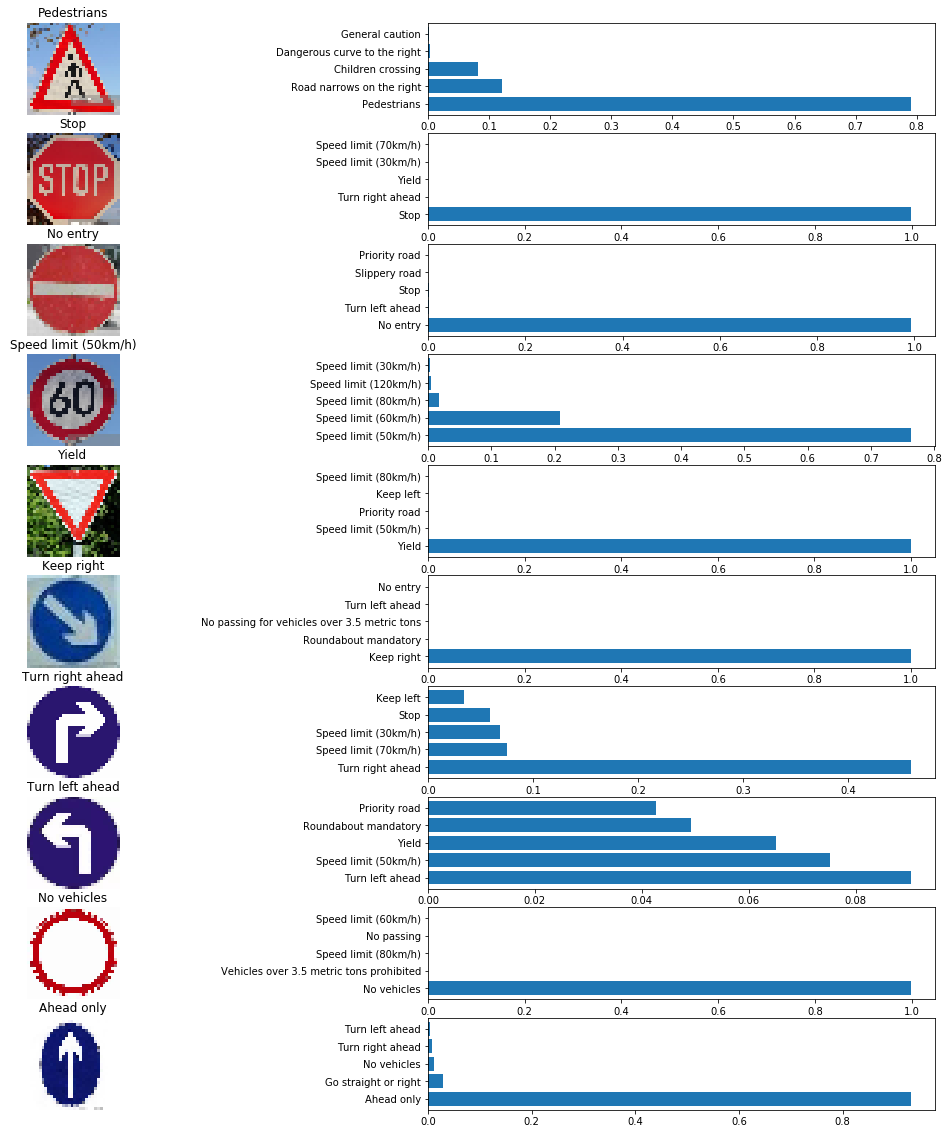

In [83]:
""" ====== 4.Test Classifier on New Images ====== """

# Loading and resizing new test images
new_test_images = []
path = '/content/drive/My Drive/new_images/'
for image in os.listdir(path):
    print(image)
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [27,14,17,2,13,38,33,34,15,35]
print("Number of new testing examples: ", len(new_test_images))

plt.figure(figsize=(20,20))
for i in range(len(new_test_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

def y_predict_model(Input_data, top_k=5):
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)
print('length=',len(new_test_images_preprocessed))

test_accuracy = 0
for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.1
print("New Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(20, 20))
for i in range(len(new_test_images_preprocessed)):
    plt.subplot(10, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    plt.axis('off')
    plt.subplot(10, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()